In [11]:
from chessnet.notebook_config import *

from chessnet.graphs import (
    read_edgelist,read_randomized_edgelist, read_rewired_edgelist,
    read_pickle, read_rewired_graph
)
from chessnet.auxiliary import linear_regression, powerlaw

In [4]:
graphs = {
    #"OTB": read_edgelist("OM_OTB_201609", directed=False),
    #"Portal": read_edgelist("OM_Portal_201510", directed=False),
    "OTB": read_pickle("OM_OTB_201609", directed=False),
    "Portal": read_pickle("OM_Portal_201510", directed=False),
}
for name, g in graphs.items():
    print(name, g.summary())

OTB IGRAPH UN-- 198494 3874277 -- 
+ attr: MeanElo (v), StdElo (v), name (v)
Portal IGRAPH UN-- 271270 7981651 -- 
+ attr: MeanElo (v), StdElo (v), name (v)


In [5]:
graphs_FV = {
    #"OTB": read_randomized_edgelist("OM_OTB_201609", mode="fabien-viger"),
    #"Portal": read_randomized_edgelist("OM_Portal_201510", mode="fabien-viger"),
    "OTB": read_randomized_edgelist("OM_OTB_201609", mode="fabien-viger"),
    "Portal": read_randomized_edgelist("OM_Portal_201510", mode="fabien-viger"),
}
for name, g in graphs_FV.items():
    print(name, g.summary())

OTB IGRAPH U--- 235454 3908800 -- 
Portal IGRAPH U--- 372169 8078583 -- 


In [6]:
graphs_rewired = {
    #"OTB": read_rewired_edgelist("OM_OTB_201609", nswap_ecount_times=2.),
    #"Portal": read_rewired_edgelist("OM_Portal_201510", nswap_ecount_times=2.),
    "OTB": read_rewired_graph("OM_OTB_201609", nswap_ecount_times=10.),
    "Portal": read_rewired_graph("OM_Portal_201510", nswap_ecount_times=10.),
}
for name, g in graphs_rewired.items():
    print(name, g.summary())

OTB IGRAPH UN-- 198494 3874277 -- 
+ attr: MeanElo (v), StdElo (v), _nx_name (v), name (v)
Portal IGRAPH UN-- 271270 7981651 -- 
+ attr: MeanElo (v), StdElo (v), _nx_name (v), name (v)


In [7]:
dfs = {}
for name, g in graphs.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero")
    })
    dfs[name] = df

In [8]:
dfs_FV = {}
for name, g in graphs_FV.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero")
    })
    dfs_FV[name] = df
del graphs_FV

In [9]:
dfs_rewired = {}
for name, g in graphs_rewired.items():
    df = pd.DataFrame({
        "k": g.degree(),
        "Cws": g.transitivity_local_undirected(mode="zero")
    })
    dfs_rewired[name] = df
del graphs_rewired

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


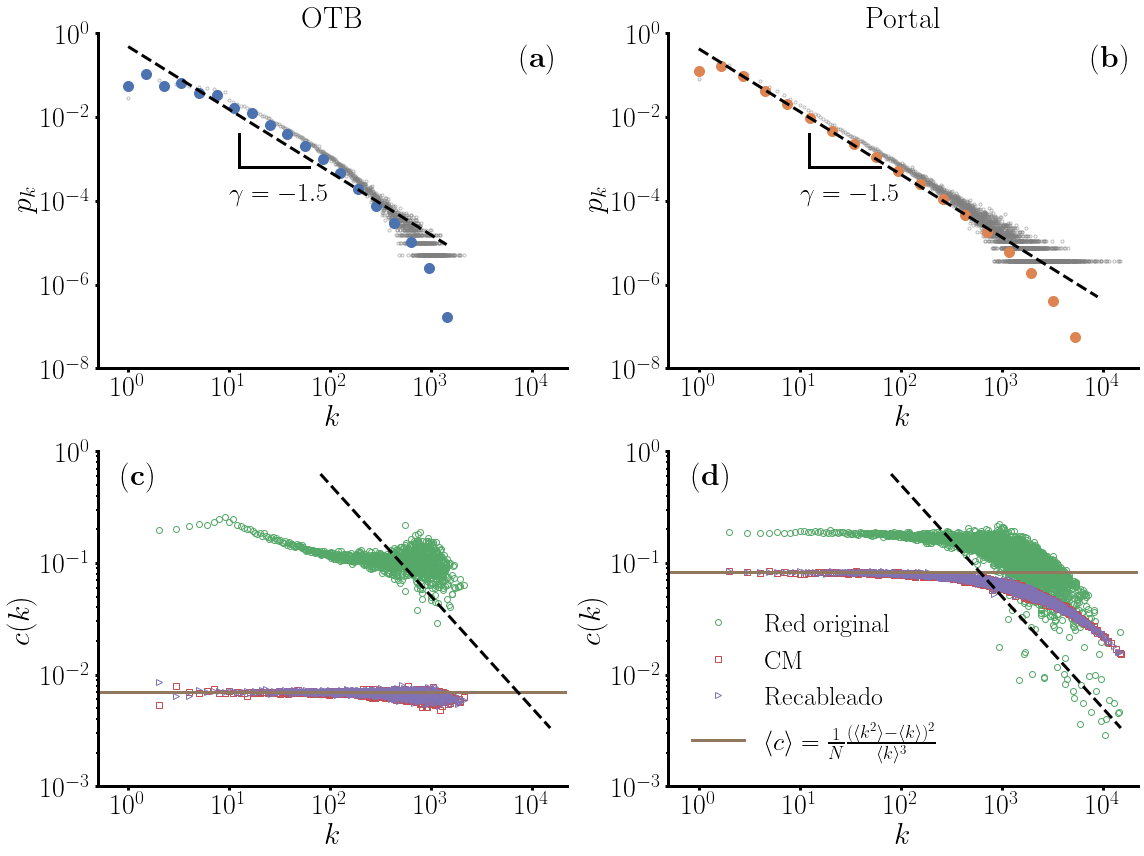

In [46]:
def plot_degree_distribution(data, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$p_k$")
    # Log scale
    bins = np.logspace(np.log10(min(data)), np.log10(max(data)+1), 20)
    freq, _ = np.histogram(data, bins=bins, density=True)
    X_log, Y_log = bins[:-1], freq

    Y_pred, slope, y_err = linear_regression(X_log[:-3], Y_log[:-3])
    c = Y_log[5] / X_log[5]**slope
    #label = r'$\gamma = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    label = r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    #ax.text(0.45, 0.73, label, fontsize=26, transform=ax.transAxes)
    ax.text(0.28, 0.5, r"$\gamma = -1.5$", fontsize=26, transform=ax.transAxes)
    #ax.plot(
    #    X_log, powerlaw(X_log, slope, c), "--", color="k", zorder=10, #label=label,
    #)

    ax.plot(
        X_log, powerlaw(X_log, -1.5, c), "--", color="k", zorder=10, #label=label,
    )

    # Lin scale
    bins = range(1, max(data)+1)
    freq, _ = np.histogram(data, bins=bins, density=True)
    X_lin, Y_lin = bins[:-1], freq

    ax.plot(X_lin, Y_lin, ".", color="gray", alpha=0.5, fillstyle="none")
    color = kwargs.get("color")
    ax.plot(X_log, Y_log, "o", markersize=10, color=color)
    return ax

def plot_avg_clustering_by_degree(df, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")

    grouped = df.groupby(by="k")["Cws"].mean()
    X = grouped.index
    Y = grouped.values
    marker = kwargs.get("marker", "o")
    fillstyle = kwargs.get("fillstyle", "full")
    label = kwargs.get("label")
    color = kwargs.get("color")
    ax.plot(X, Y, marker, fillstyle=fillstyle, label=label, color=color)

maxk = max([max(g.degree()) for g in graphs.values()])

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
for ax in axes.flatten():
    ax.set_xlim(0.5, 1.5*maxk)
axes[0,0].set_title(database_latex["OTB"], fontsize=30)
axes[0,1].set_title(database_latex["Portal"], fontsize=30)
#axes[0,0].plot([0.45, 0.65], [0.7, 0.7], "-", color="k", transform=axes[0,0].transAxes)
#axes[0,0].plot([0.65, 0.65], [0.55, 0.7], "-", color="k", transform=axes[0,0].transAxes)
#axes[0,1].plot([0.45, 0.65], [0.7, 0.7], "-", color="k", transform=axes[0,1].transAxes)
#axes[0,1].plot([0.65, 0.65], [0.55, 0.7], "-", color="k", transform=axes[0,1].transAxes)
axes[0,0].plot([0.3, 0.45], [0.6, 0.6], "-", color="k", transform=axes[0,0].transAxes)
axes[0,0].plot([0.3, 0.3], [0.6, 0.7], "-", color="k", transform=axes[0,0].transAxes)
axes[0,1].plot([0.3, 0.45], [0.6, 0.6], "-", color="k", transform=axes[0,1].transAxes)
axes[0,1].plot([0.3, 0.3], [0.6, 0.7], "-", color="k", transform=axes[0,1].transAxes)
for i, (name, df) in enumerate(dfs.items()):
    ax = axes[0,i]
    ax.text(0.9, 0.9, panels[i], fontsize=30, transform=ax.transAxes)
    plot_degree_distribution(df["k"], ax=ax, color=f"C{i}")

    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_ylim(1e-8, 1)

    ax = axes[1,i]
    ax.text(0.05, 0.9, panels[2+i], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$c(k)$")
    plot_avg_clustering_by_degree(
        df, ax=ax, fillstyle="none", label=r"$\mathrm{Red\;original}$", color="C2"
    )
    ax.set_xticks([1, 10, 100, 1000, 10000])
    ax.set_ylim(1e-3, 1)

for i, (name, df) in enumerate(dfs_FV.items()):
    ax = axes[1,i]
    label = r"$\mathrm{CM}$"
    plot_avg_clustering_by_degree(
        df, ax=ax, marker="s", fillstyle="none", label=label, color="C3"
    )


for i, (name, df) in enumerate(dfs_rewired.items()):
    ax = axes[1,i]
    label = r"$\mathrm{Recableado}$"
    plot_avg_clustering_by_degree(
        df, ax=ax, marker=">", fillstyle="none", label=label, color="C4"
    )
    meank = df.k.mean()
    meank2 = (df.k**2).mean()
    N = len(df)
    xline = (1/N) * (meank2 - meank)**2 / meank**3
    label = r"$\langle c \rangle = \frac{1}{N} \frac{(\langle k^2\rangle - \langle k\rangle)^2}{\langle k \rangle^3}$"
    ax.axhline(xline, color="C5", label=label)

    X = np.array([80., 15000.])
    Y = powerlaw(X, -1, 50)
    ax.plot(X, Y, linestyle="--", color="k")
    ax.set_xticks([1, 10, 100, 1000, 10000])

axes[0,0].legend(frameon=False)
axes[0,1].legend(frameon=False)
axes[1,1].legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "pk_and_ck.pdf")
plt.show()